# Computing actual viscosity from ''grid scaled''

This is kind of documented in the comments of `pkg/mom_common/mom_calc_visc.F`, and is decided by options in the first namelist of the `data` file. The options chosen are output to STDOUT.0000, but the final viscosity value is not. This is verification to ensure what I compute is correct.

The 1/32$^\circ$ PIG domain I inherited has the following viscosity parameters set in data

- `viscAr`=10$^{-3}$   [m$^2$/s]  
- `viscAhGrid`=0.05    [unitless]
- `viscA4Grid`=0.01    [unitless]

where the first is a vertical viscosity, and it's clear what the value is. The 'grid scaled' options are less clear. The header for `pkg/mom_common/mom_calc_visc.F` gives the following equation:

#### Laplacian or harmonic viscosity = 
## $\nu_{Ah} + \frac{L^2}{4\Delta T }\nu_{Ah\text{Grid}} + \nu_{\text{Leith}} +\nu_{\text{Smag}} $

#### Biharmonic viscosity = 
## $\nu^B_{A4} + \frac{L^4}{32\Delta T }\nu^B_{A4\text{Grid}} + \nu^B_{\text{Leith}} +\nu^B_{\text{Smag}} $

where $\nu_{Ah}$ = `viscAh`, $\nu_{Ah\text{Grid}}$ = `viscAhGrid`, and these are parameters set in `data`, and `viscAh` can be set specifically for tracer (a.k.a. divergence) and vorticity points as `viscAh_D` and `viscAh_Z` respectively. 
The separate divergence and vorticity points are what is actually used in the MITgcm.    

Similarly $\nu^B_{Ah}$ =`viscA4` and $\nu^B_{A4\text{Grid}}$ =`viscA4Grid` are the corresponding biharmonic viscosity settings.

$\nu_{\text{Leith}}$ and $\nu^B_{\text{Leith}}$ are the contributions to viscosity via the Leith scheme, see `mom_calc_visc.F` for details. 
These are turned on by setting `viscC2Leith`, `viscC2LeithD`, `viscC4Leith`, or `viscC4LeithD` to nonzero values in `data`.

$\nu_{\text{Smag}}$ and $\nu^B_{\text{Smag}}$ are the contributions to viscosity via the Smagorinsky scheme, see `mom_calc_visc.F` for details. 
These are turned on by setting `viscC2Smag` or `viscC4Smag` to nonzero values in `data`.


### Focusing on the grid scaled computation, as in my setup

So for my domain, the grid scaled viscosities are defined above and $\Delta T$ = 300s. So just need to compute $L$.

By default, $L^2 = \frac{2}{\big(\frac{1}{\Delta x}\big)^2 + \big(\frac{1}{\Delta y}\big)^2}$, unless `useAreaViscLength`=`.TRUE.` in `data`, in which case $L^2=$`rA` (defined in `GRID.h` as the "R-face area in m$^2$",
see `pkg/mom_common/mom_init_fixed.F`.

NOTE: $L^2$ is computed as `L2_D` and `L2_Z`, and $L^4$ is `L4_D` and `L4_Z` in `pkg/mom_common/mom_init_fixed.F`

Here $\Delta x,y$ = `dxF`,`dyF` specified in `GRID.h`

In `data` it's specified `usingSphericalPolarGrid`=`.TRUE.` and
- `delX` = 0.03125$^{\circ}$
- `delY` = degrees specified by a binary file

and `dxF`,`dyF` are grid varying parameters computed in `model/src/ini_spherical_polar_grid.F`. 
Note that here `dxF`=`dxG` and `dyF`=`dyG`.

## Computation of L and viscosities

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from xmitgcm import open_mdsdataset
import xgcm

from pig_tools import diag_plot

In [3]:
diags_dir = '/workspace/results/pig/viscosity-diagnostics'
grid_dir = '/workspace/grids/pig_32'
ds = open_mdsdataset(data_dir=diags_dir,
                     grid_dir=grid_dir,
                     geometry='sphericalpolar'
                    )
xgrid = xgcm.Grid(ds)

/workspace/xmitgcm/xmitgcm/utils.py:429: UserWarning: Not sure what to do with rlev = L
  warnings.warn("Not sure what to do with rlev = " + rlev)
/workspace/xmitgcm/xmitgcm/mds_store.py:269: FutureWarning: iteration over an xarray.Dataset will change in xarray v0.11 to only include data variables, not coordinates. Iterate over the Dataset.variables property instead to preserve existing behavior in a forwards compatible manner.
  for vname in ds:


In [4]:
print(ds)

<xarray.Dataset>
Dimensions:    (XC: 100, XG: 100, YC: 120, YG: 120, Z: 50, Zl: 50, Zp1: 51, Zu: 50, time: 3)
Coordinates:
  * XC         (XC) >f4 -102.359375 -102.328125 ... -99.296875 -99.265625
  * YC         (YC) >f4 -75.44177 -75.43392 -75.426056 ... -74.485695 -74.47733
  * XG         (XG) >f4 -102.375 -102.34375 -102.3125 ... -99.3125 -99.28125
  * YG         (YG) >f4 -75.4457 -75.43784 -75.42999 ... -74.489876 -74.481514
  * Z          (Z) >f4 -10.0 -30.0 -50.0 -70.0 ... -930.0 -950.0 -970.0 -990.0
  * Zp1        (Zp1) >f4 0.0 -20.0 -40.0 -60.0 ... -940.0 -960.0 -980.0 -1000.0
  * Zu         (Zu) >f4 -20.0 -40.0 -60.0 -80.0 ... -940.0 -960.0 -980.0 -1000.0
  * Zl         (Zl) >f4 0.0 -20.0 -40.0 -60.0 ... -920.0 -940.0 -960.0 -980.0
    rA         (YC, XC) >f4 dask.array<shape=(120, 100), chunksize=(120, 100)>
    dxG        (YG, XC) >f4 dask.array<shape=(120, 100), chunksize=(120, 100)>
    dyG        (YC, XG) >f4 dask.array<shape=(120, 100), chunksize=(120, 100)>
    Depth   

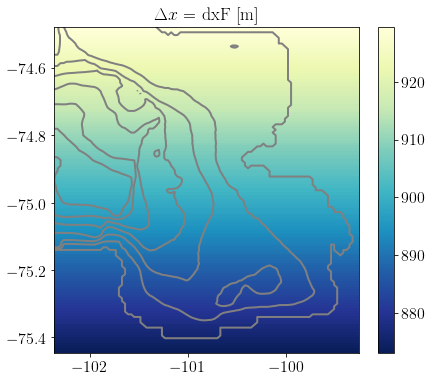

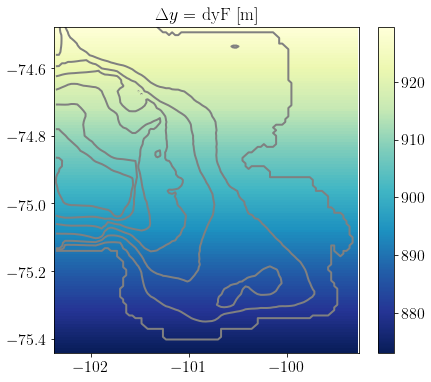

In [5]:
diag_plot(ds.XC,ds.YG,ds.dxG,title1='$\Delta x$ = dxF [m]',depth=ds.Depth)
diag_plot(ds.XG,ds.YC,ds.dyG,title1='$\Delta y$ = dyF [m]',depth=ds.Depth)

Interpolate `dxG` and `dyG` to cell centers to compute divergence point viscosity using xgcm

In [6]:
L2 = 2 / ( 1 / xgrid.interp(ds.dxG, axis='Y', to='center')**2 + 1/xgrid.interp(ds.dyG, axis='X',to='center')**2)
print(L2)

<xarray.DataArray (YC: 120, XC: 100)>
dask.array<shape=(120, 100), dtype=float32, chunksize=(119, 99)>
Coordinates:
  * YC       (YC) >f4 -75.44177 -75.43392 -75.426056 ... -74.485695 -74.47733
  * XC       (XC) >f4 -102.359375 -102.328125 ... -99.296875 -99.265625


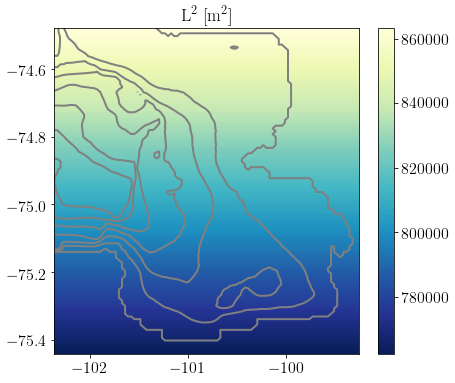

In [7]:
diag_plot(ds.XC,ds.YC,L2,title1='L$^2$ [m$^2$]',depth=ds.Depth)

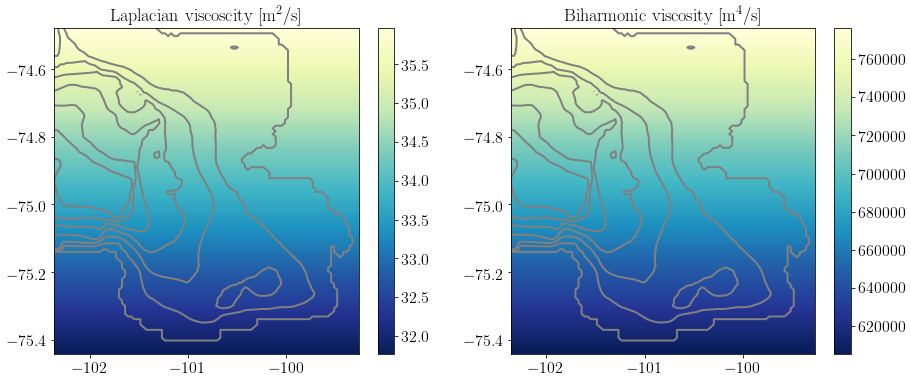

In [8]:
# And finally, compute viscosity
deltaT = 300
viscAhGrid = 0.05
viscA4Grid = 0.01

nu = L2 / 4 / deltaT * viscAhGrid
nu4= L2**2 / 32/ deltaT * viscA4Grid

diag_plot(ds.XC,ds.YC,nu,nu4,
          title1='Laplacian viscoscity [m$^2$/s]',title2='Biharmonic viscosity [m$^4$/s]',depth=ds.Depth)

### Compare these to diagnosed viscosity

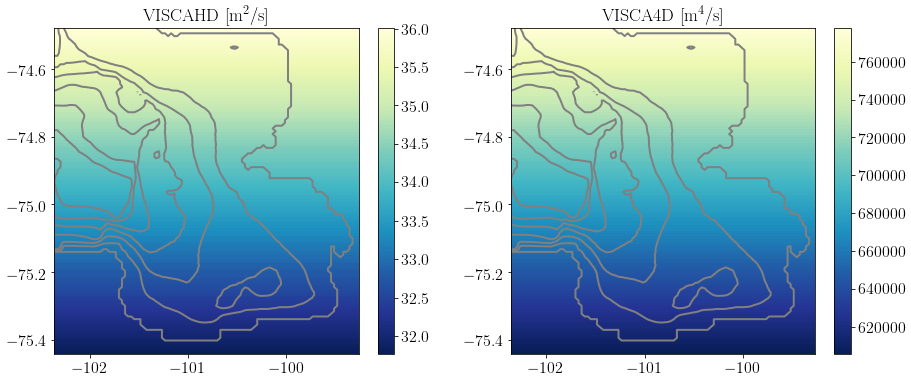

In [9]:
diag_plot(ds.XC,ds.YC,ds.VISCAHD,ds.VISCA4D,
          title1='VISCAHD [m$^2$/s]',title2='VISCA4D [m$^4$/s]',depth=ds.Depth)

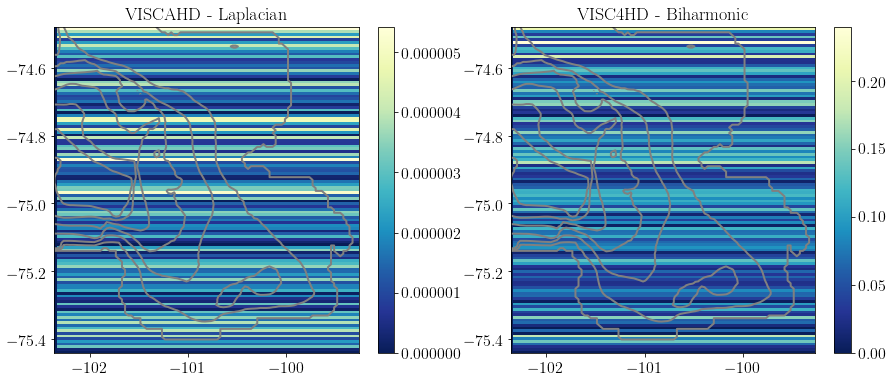

In [22]:
# Remove boundary points and show difference

laplace_diff = np.abs(ds.VISCAHD.isel(Z=0,time=0)-nu)
biharmonic_diff = np.abs(ds.VISCA4D.isel(Z=0,time=0)-nu4)

bdy_cond = (ds.XC!=ds.XC.isel(XC=-1)) & (ds.XC!=ds.XC.isel(XC=0)) & \
           (ds.YC!=ds.YC.isel(YC=-1)) & (ds.YC!=ds.YC.isel(YC=0))

ldw = laplace_diff.where( bdy_cond, 0 )
bdw = biharmonic_diff.where( bdy_cond, 0 )

diag_plot(ds.XC,ds.YC,ldw,bdw,
          title1='VISCAHD - Laplacian',title2=('VISC4HD - Biharmonic'),depth=ds.Depth)

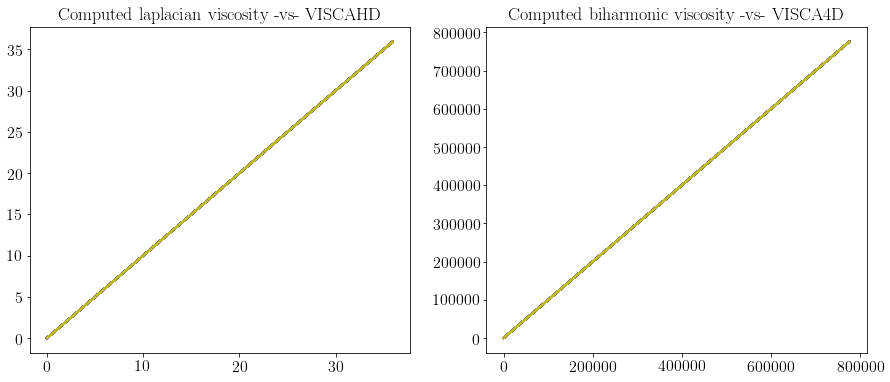

In [25]:
plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
plt.plot(ds.VISCAHD.where(bdy_cond,0).isel(Z=0,time=0).values,nu.where(bdy_cond,0).values)
plt.title('Computed laplacian viscosity -vs- VISCAHD')
plt.subplot(1,2,2)
plt.plot(ds.VISCA4D.where(bdy_cond,0).isel(Z=0,time=0).values,nu4.where(bdy_cond,0).values)
plt.title('Computed biharmonic viscosity -vs- VISCA4D')
plt.show()